# Identificación de Parámetros - Principio de Mínima Acción

## Formulación Lagrangiana del Levitador Magnético y 4 Metaheurísticos

El Principio de Mínima Acción (Principle of Least Action) es un concepto fundamental en física, especialmente en mecánica clásica y cuántica. Establece que la trayectoria que sigue un sistema físico entre dos estados dados es aquella que minimiza una cantidad llamada 'acción'. La acción se define como la integral de la función Lagrangiana (energía cinética menos energía potencial) a lo largo del tiempo. Las ecuaciones de Euler-Lagrange, que describen el movimiento del sistema, se derivan de este principio.

La identificación de parámetros para el levitador magnético, el Principio de Mínima Acción se aplica de la siguiente manera:

**Formulación Lagrangiana:** El Lagrangiano ($\mathcal{L}$) del levitador, que incluye términos de energía cinética, potencial gravitatoria y energía magnética almacenada en la bobina ($\frac{1}{2}L(y)i^2$). A partir de este Lagrangiano, se derivan las ecuaciones dinámicas (Euler-Lagrange) que rigen el comportamiento mecánico y eléctrico del sistema.

**Lagrangiano:** $\mathcal{L} = \frac{1}{2}m\dot{y}^2 + mgy + \frac{1}{2}L(y)i^2$

**Identificación de Parámetros como Optimización:** El objetivo del cuaderno es encontrar los parámetros ($k_0, k, a, m, R_0, \alpha$) que mejor describen el comportamiento real del levitador. Para ello, se utilizan metaheurísticos (Differential Evolution, PSO, GWO,MFO) para minimizar una 'función de fitness' (costo o error).

**Parámetros a identificar (6D):** $k_0, k, a, m, R , α $

**Metaheurísticos implementados:**
1. Differential Evolution (DE/best/1)
2. Particle Swarm Optimization (PSO)
3. Grey Wolf Optimizer (GWO)
4. Moth Flame Optimizer (MFO)

**Las Funciones de Fitness:** Las funciones energy_balance_fitness y fitness_pinn_mejorado son cruciales aquí. Estas funciones están diseñadas para penalizar las desviaciones entre el comportamiento predicho por el modelo (usando un conjunto de parámetros propuestos) y los datos experimentales. Incorporan:

**Balance de fuerzas (ecuación mecánica):** Comparan la fuerza magnética calculada con la fuerza gravitatoria y la inercia $(m \cdot \mathcal{a})$.

**Balance de voltaje (ecuación eléctrica):** Comparan el voltaje medido con el voltaje calculado a partir de la resistencia, inductancia y la dinámica de corriente y posición (Ley de Kirchhoff).
Balance de potencia: En energy_balance_fitness, se verifica que la potencia de entrada sea igual a la suma de las pérdidas resistivas, la variación de energía magnética y la variación de energía mecánica.

Aunque no se minimiza directamente la 'acción' en sí, la minimización de estas funciones de fitness es una aproximación numérica para encontrar el conjunto de parámetros que hace que el sistema 'obedezca' las leyes físicas derivadas del principio de mínima acción y otras leyes fundamentales (como Kirchhoff para el circuito eléctrico). Es decir, se busca el conjunto de parámetros para el cual las ecuaciones dinámicas del sistema se satisfacen lo mejor posible con los datos experimentales.

In [ ]:
# Setup
import subprocess, sys, platform
print("Verificando GPU...")
try:
    print(subprocess.check_output(['nvidia-smi'], text=True))
except: print("Sin GPU")

IN_COLAB = 'google.colab' in sys.modules
!pip install -q "numpy<2.1.0" "ml-dtypes>=0.5.1"
if IN_COLAB:
    !pip install -q "jax[cuda12]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
else:
    !pip install -q jax jaxlib
!pip install -q scipy pandas matplotlib tqdm plotly ipywidgets
print("Dependencias instaladas")

Verificando GPU...
Fri Jan  9 02:35:09 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P8             15W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+----------------------------

In [ ]:
import jax
import jax.numpy as jnp
from jax import random, jit, vmap
from jax.lax import scan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json, time, os
from datetime import datetime
from tqdm.auto import tqdm
from functools import partial
import plotly.graph_objects as go
from IPython.display import display, update_display
import uuid

print(f"JAX devices: {jax.devices()}")
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

JAX devices: [CudaDevice(id=0)]


In [ ]:
REPO_URL = "https://github.com/JRavenelco/levitador-benchmark.git"
if not os.path.exists("levitador-benchmark"):
    !git clone {REPO_URL}
    %cd levitador-benchmark
elif os.getcwd().split(os.sep)[-1] != "levitador-benchmark":
    %cd levitador-benchmark
!ls -la data/*.txt 2>/dev/null || echo "No data"
!ls -la data/sesiones_kan_pinn/*.txt 2>/dev/null || echo "No KAN-PINN data"

/content/levitador-benchmark
-rw-r--r-- 1 root root 329914 Jan  8 23:48 data/datos_levitador_20251024_162706.txt
-rw-r--r-- 1 root root 329914 Jan  8 23:48 data/datos_levitador.txt
-rw-r--r-- 1 root root 247380 Jan  8 23:48 data/datos_zonas_faltantes.txt
-rw-r--r-- 1 root root 157405 Jan  8 23:48 data/kan_validation_data.txt
-rw-r--r-- 1 root root 907098 Jan  8 23:48 data/mega_controlled_dataset.txt
-rw-r--r-- 1 root root 200087 Jan  8 23:48 data/MONIT_MAESTRO.txt
-rw-r--r-- 1 root root 268547 Jan  8 23:48 data/MONIT_SWEEP.txt
-rw-r--r-- 1 root root 204924 Jan  8 23:48 data/sesiones_kan_pinn/dataset_chirp_20251217_210058.txt
-rw-r--r-- 1 root root 172592 Jan  8 23:48 data/sesiones_kan_pinn/dataset_constante_20251217_205611.txt
-rw-r--r-- 1 root root 172590 Jan  8 23:48 data/sesiones_kan_pinn/dataset_escalon_20251217_205858.txt
-rw-r--r-- 1 root root 201479 Jan  8 23:48 data/sesiones_kan_pinn/dataset_multiescalon_20251217_210203.txt
-rw-r--r-- 1 root root 166501 Jan  8 23:48 data/sesion

In [ ]:
# Archivos disponibles para identificacion
DATA_FILES = {
    # === MEGA DATASET PRE-FILTRADO (RECOMENDADO) ===
    'MEGA_CONTROLADO': 'data/mega_controlled_dataset.txt',  # 19534 muestras, 12 fuentes, solo datos controlados

    # === DATOS INDIVIDUALES ===
    'MONIT_SWEEP': 'data/MONIT_SWEEP.txt',
    'datos_zonas_faltantes': 'data/datos_zonas_faltantes.txt',
    'MONIT_MAESTRO': 'data/MONIT_MAESTRO.txt',
    'datos_levitador': 'data/datos_levitador.txt',

    # === SESIONES KAN-PINN ===
    'chirp': 'data/sesiones_kan_pinn/dataset_chirp_20251217_210058.txt',
    'constante': 'data/sesiones_kan_pinn/dataset_constante_20251217_205611.txt',
    'escalon': 'data/sesiones_kan_pinn/dataset_escalon_20251217_205858.txt',
    'multiescalon': 'data/sesiones_kan_pinn/dataset_multiescalon_20251217_210203.txt',
    'senoidal': 'data/sesiones_kan_pinn/dataset_senoidal_20251217_205952.txt',
}

def load_data(filepath, subsample=1):
    try:
        df = pd.read_csv(filepath, sep='\\s+', comment='#', header=None, encoding='utf-8')
    except UnicodeDecodeError:
        df = pd.read_csv(filepath, sep='\\s+', comment='#', header=None, encoding='latin1')
    if subsample > 1:
        df = df.iloc[::subsample].reset_index(drop=True)

    # Extract columns: t, sp, y, i, u
    t = df[0].values.astype(np.float32)
    sp = df[1].values.astype(np.float32)
    y = df[2].values.astype(np.float32)
    i = df[3].values.astype(np.float32)
    u = df[4].values.astype(np.float32)

    # Create validity mask (1=valid, 0=invalid/gap)
    mask = np.ones_like(t, dtype=np.float32)
    # Mask edges to avoid boundary derivative artifacts
    if len(mask) > 10:
        mask[:5] = 0
        mask[-5:] = 0

    return {'t': t, 'y': y, 'i': i, 'u': u, 'sp': sp, 'mask': mask}

def filter_controlled(data):
    '''Filtra datos donde la esfera esta levitando (y > 0.5mm y < 30mm)'''
    mask_ctrl = (data['y'] > 0.0005) & (data['y'] < 0.030)
    filtered = {k: v[mask_ctrl] for k, v in data.items()}
    pct = 100 * len(filtered['t']) / (len(data['t']) + 1e-9)
    return filtered, pct

def extract_high_dynamics(data, threshold_pct=90):
    '''Extrae segmentos con alta variacion de corriente/posicion'''
    # Calculo aproximado de aceleracion
    dy = np.gradient(data['y'])
    ddy = np.gradient(dy)
    metric = np.abs(ddy)  # Aceleracion como proxy de dinamica

    threshold = np.percentile(metric, threshold_pct)
    mask = metric > threshold

    # Dilatar mascara para incluir contexto temporal
    kernel = np.ones(50)  # +/- 25 muestras de contexto
    mask_dilated = np.convolve(mask.astype(float), kernel, mode='same') > 0

    filtered = {k: v[mask_dilated] for k, v in data.items()}
    n_selected = sum(mask_dilated)
    pct = 100 * n_selected / len(data['t'])

    print(f"  Zonas de alta dinamica: {n_selected}/{len(data['t'])} ({pct:.1f}%)")
    print(f"  Umbral aceleracion: {threshold:.2f} m/s^2 (percentil {threshold_pct})")

    return filtered, pct

def analyze_data(data, name, show_filtered=True):
    n_total = len(data['t'])
    sp_range = (data['sp'].max() - data['sp'].min()) * 1000
    y_range = (data['y'].max() - data['y'].min()) * 1000
    i_range = data['i'].max() - data['i'].min()
    n_setpoints = len(np.unique(np.round(data['sp'], 4)))
    print(f"Dataset {name}: {n_total} muestras, {n_setpoints} setpoints")
    print(f"   SP: {data['sp'].min()*1000:.1f}-{data['sp'].max()*1000:.1f}mm | y: {y_range:.1f}mm | i: {i_range:.2f}A")
    return {'name': name, 'samples': n_total, 'setpoints': n_setpoints,
            'sp_range': sp_range, 'y_range': y_range, 'i_range': i_range}

def create_mega_dataset(file_dict, subsample=1, filter_ctrl=True):
    '''Combina TODOS los archivos en un mega-dataset con datos controlados'''
    all_data = {k: [] for k in ['t', 'sp', 'y', 'i', 'u', 'mask']}
    t_offset = 0
    stats = []

    print("="*60)
    print("CREANDO MEGA-DATASET CON DATOS CONTROLADOS")
    print("="*60)

    for name, path in file_dict.items():
        try:
            d = load_data(path, subsample)
            n_original = len(d['t'])

            if filter_ctrl:
                d, pct = filter_controlled(d)
                print(f"{name}: {len(d['t'])}/{n_original} muestras ({pct:.1f}% controladas)")
            else:
                print(f"{name}: {len(d['t'])} muestras")

            if len(d['t']) > 0:
                # Invalidar bordes de unión para evitar derivadas espurias
                d['mask'][:5] = 0
                d['mask'][-5:] = 0

                # Resetear tiempo y agregar offset
                d['t'] = d['t'] - d['t'][0] + t_offset
                for k in all_data.keys():
                    all_data[k].extend(d[k])
                t_offset = all_data['t'][-1] + 0.1  # Gap entre datasets
                stats.append({'name': name, 'samples': len(d['t'])})
        except Exception as e:
            print(f"Error {name}: {e}")

    mega = {k: np.array(v, dtype=np.float32) for k, v in all_data.items()}
    print("="*60)
    print(f"MEGA-DATASET: {len(mega['t'])} muestras totales de {len(stats)} archivos")
    print("="*60)
    return mega, stats

print("="*60)
print("ARCHIVOS DISPONIBLES PARA IDENTIFICACION")
print("="*60)
for name, path in DATA_FILES.items():
    try:
        d = load_data(path, 1)
        d_filt, pct = filter_controlled(d)
        analyze_data(d, name)
        print(f"   -> Datos controlados: {len(d_filt['t'])} ({pct:.1f}%)")
    except Exception as e:
        print(f"Error {name}: {e}")
print("="*60)

ARCHIVOS DISPONIBLES PARA IDENTIFICACION
Dataset MEGA_CONTROLADO: 19534 muestras, 15 setpoints
   SP: 3.8-12.0mm | y: 14.0mm | i: 0.82A
   -> Datos controlados: 19534 (100.0%)
Dataset MONIT_SWEEP: 6163 muestras, 11 setpoints
   SP: 5.0-18.0mm | y: 20.7mm | i: 0.83A
   -> Datos controlados: 5708 (92.6%)
Dataset datos_zonas_faltantes: 5663 muestras, 10 setpoints
   SP: 9.0-18.0mm | y: 20.7mm | i: 0.83A
   -> Datos controlados: 5208 (92.0%)
Dataset MONIT_MAESTRO: 4625 muestras, 5 setpoints
   SP: 4.5-10.0mm | y: 20.3mm | i: 0.83A
   -> Datos controlados: 4329 (93.6%)
Dataset datos_levitador: 7673 muestras, 2 setpoints
   SP: 4.5-5.0mm | y: 20.4mm | i: 0.83A
   -> Datos controlados: 6364 (82.9%)
Dataset chirp: 3487 muestras, 189 setpoints
   SP: 0.0-20.5mm | y: 1.2mm | i: 0.01A
   -> Datos controlados: 3487 (100.0%)
Dataset constante: 2989 muestras, 141 setpoints
   SP: 0.0-20.0mm | y: 2.2mm | i: 0.02A
   -> Datos controlados: 2989 (100.0%)
Dataset escalon: 2989 muestras, 103 setpoints
   

*** MODO 4: MEGA_CONTROLADO (Pre-filtrado, RECOMENDADO) ***
  Cargadas 19534 muestras de levitacion controlada
Dataset MEGA_CONTROLADO: 19534 muestras, 15 setpoints
   SP: 3.8-12.0mm | y: 14.0mm | i: 0.82A

Dataset final: MEGA_CONTROLADO
  Muestras: 19534, Setpoints: 15
  Calidad para identificacion: EXCELENTE


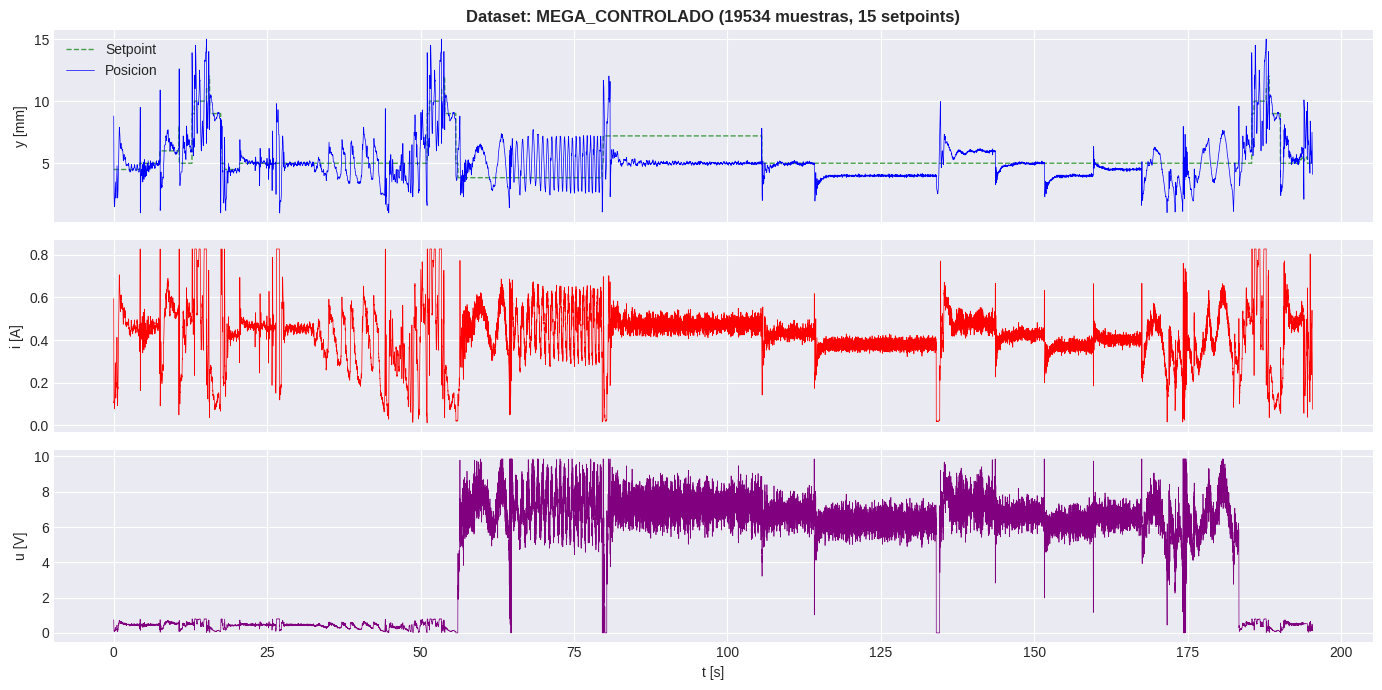

In [ ]:
# =================================================================
# SELECCION DE DATOS - Modificar aqui
# =================================================================
# Modo 1: Un solo archivo
# Modo 2: Combinar archivos seleccionados
# Modo 3: MEGA-DATASET (fusion en vivo de todos los archivos)
# Modo 4: MEGA_CONTROLADO PRE-FILTRADO (19534 muestras, RECOMENDADO)
# =================================================================

MODE = 4  # 1=single, 2=combine, 3=fusion-live, 4=MEGA_CONTROLADO (RECOMENDADO)

SELECTED_FILES = ['MONIT_SWEEP', 'datos_zonas_faltantes']  # Para modo 1 y 2
SUBSAMPLE = 1  # Submuestreo (1=sin submuestreo, MEGA ya esta limpio)
FILTER_CONTROLLED = True  # Filtrar solo datos donde esfera levita

# === Filtro de zonas de alta dinamica ===
USE_HIGH_DYNAMICS = False  # MEGA ya incluye alta dinamica
DYNAMICS_PERCENTILE = 75   # Top 25% de aceleracion (75 = mas selectivo)

if MODE == 4:
    # MEGA_CONTROLADO: Dataset pre-filtrado con 19534 muestras de 12 fuentes
    print("*** MODO 4: MEGA_CONTROLADO (Pre-filtrado, RECOMENDADO) ***")
    data = load_data(DATA_FILES['MEGA_CONTROLADO'], SUBSAMPLE)
    DATA_NAME = 'MEGA_CONTROLADO'
    print(f"  Cargadas {len(data['t'])} muestras de levitacion controlada")

elif MODE == 3:
    # MEGA-DATASET: Combina TODOS los archivos con datos controlados
    print("*** MODO 3: MEGA-DATASET ***")
    data, mega_stats = create_mega_dataset(DATA_FILES, subsample=SUBSAMPLE, filter_ctrl=FILTER_CONTROLLED)
    DATA_NAME = 'MEGA-DATASET'

elif MODE == 2 and len(SELECTED_FILES) > 1:
    # Combinar archivos seleccionados
    print(f"*** MODO 2: Combinando {SELECTED_FILES} ***")
    all_data = {k: [] for k in ['t', 'sp', 'y', 'i', 'u']}
    t_offset = 0
    for fname in SELECTED_FILES:
        d = load_data(DATA_FILES[fname], SUBSAMPLE)
        if FILTER_CONTROLLED:
            d, pct = filter_controlled(d)
            print(f"  {fname}: {len(d['t'])} muestras controladas ({pct:.1f}%)")
        d['t'] = d['t'] - d['t'][0] + t_offset
        for k in all_data.keys():
            all_data[k].extend(d[k])
        t_offset = all_data['t'][-1] + 0.1
    data = {k: np.array(v, dtype=np.float32) for k, v in all_data.items()}
    DATA_NAME = '+'.join(SELECTED_FILES)

else:
    # Modo 1: Un solo archivo
    print(f"*** MODO 1: Archivo unico ***")
    DATA_NAME = SELECTED_FILES[0]
    data = load_data(DATA_FILES[DATA_NAME], SUBSAMPLE)
    if FILTER_CONTROLLED:
        data, pct = filter_controlled(data)
        print(f"  Filtrado: {len(data['t'])} muestras controladas ({pct:.1f}%)")

# === APLICAR FILTRO DE ALTA DINAMICA ===
if USE_HIGH_DYNAMICS:
    print(f"\n*** EXTRAYENDO ZONAS DE ALTA DINAMICA (percentil {DYNAMICS_PERCENTILE}) ***")
    n_antes = len(data['t'])
    data, pct_dyn = extract_high_dynamics(data, threshold_pct=DYNAMICS_PERCENTILE)
    print(f"  Reduccion: {n_antes} -> {len(data['t'])} muestras")
    DATA_NAME += f"_dyn{100-DYNAMICS_PERCENTILE}"

stats = analyze_data(data, DATA_NAME)
n_setpoints = stats['setpoints']
quality = 'EXCELENTE' if n_setpoints >= 15 else 'MUY BUENA' if n_setpoints >= 10 else 'BUENA' if n_setpoints >= 5 else 'BASICA'
print(f"\nDataset final: {DATA_NAME}")
print(f"  Muestras: {stats['samples']}, Setpoints: {n_setpoints}")
print(f"  Calidad para identificacion: {quality}")

# Visualizacion
fig, ax = plt.subplots(3, 1, figsize=(14, 7), sharex=True)
ax[0].plot(data['t'], data['sp']*1000, 'g--', lw=1, alpha=0.7, label='Setpoint')
ax[0].plot(data['t'], data['y']*1000, 'b-', lw=0.5, label='Posicion')
ax[0].set_ylabel('y [mm]'); ax[0].legend(); ax[0].grid(True)
ax[0].set_title(f'Dataset: {DATA_NAME} ({stats["samples"]} muestras, {n_setpoints} setpoints)', fontweight='bold')
ax[1].plot(data['t'], data['i'], 'r-', lw=0.5); ax[1].set_ylabel('i [A]'); ax[1].grid(True)
ax[2].plot(data['t'], data['u'], 'purple', lw=0.5); ax[2].set_ylabel('u [V]'); ax[2].set_xlabel('t [s]'); ax[2].grid(True)
plt.tight_layout(); plt.show()

In [ ]:
t_jax = jnp.array(data['t'])
y_jax = jnp.array(data['y'])
i_jax = jnp.array(data['i'])
u_jax = jnp.array(data['u'])
mask_jax = jnp.array(data['mask'])  # Máscara de validez (0=gap, 1=valid)

dt_jax = jnp.diff(t_jax, prepend=t_jax[0])
dt_jax = dt_jax.at[0].set(dt_jax[1])
dt_mean = float(jnp.mean(dt_jax))   #promedio del paso de tiempo

dy_jax = jnp.gradient(y_jax, dt_mean) # velodidad
ddy_jax = jnp.gradient(dy_jax, dt_mean)
di_jax = jnp.gradient(i_jax, dt_mean)

y0, i0 = float(y_jax[0]), float(i_jax[0])
print(f"GPU: dt={dt_mean:.4f}s, y0={y0*1000:.2f}mm, i0={i0:.3f}A")

GPU: dt=0.0100s, y0=8.80mm, i0=0.594A


## Modelo Fisico Lagrangiano - 6 Parametros

**Inductancia:** $L(y) = k_0 + \frac{k}{1+y/a}$

**Resistencia termica:** $R(t) = R_0 + \alpha \cdot t$ (deriva termica de la bobina)

**Parametros a identificar (6D):** $[k_0, k, a, m, R_0, \alpha]$

**Residuos Euler-Lagrange:**
- Mecanico: $m\ddot{y} = mg - \frac{1}{2}i^2|\frac{dL}{dy}|$
- Electrico: $u = R(t)i + L\frac{di}{dt} + i\frac{dL}{dy}\frac{dy}{dt}$

In [ ]:
GRAVITY = 9.81

# Parámetros de referencia ACTUALIZADOS POR USUARIO
M_REF = 0.009      # 9g (Mantenemos masa nominal)
R0_REF = 3.4627    # 3.4627 ohm
K0_REF = 0.005522  # 5.5220 mH
K_REF = 0.0200368  # 20.0368 mH
A_REF = 0.0030368  # 3.0368 mm
ALPHA_REF = 0.001487 # 0.001487 ohm/s

print("="*60)
print("MODELO DE 6 PARAMETROS CON RESISTENCIA TERMICA")
print("="*60)
print(f"Ref: k0={K0_REF*1000:.4f}mH, k={K_REF*1000:.4f}mH, a={A_REF*1000:.4f}mm")
print(f"     m={M_REF*1000:.1f}g, R0={R0_REF:.4f}ohm, alpha={ALPHA_REF:.6f}")
print("="*60)

@jit
def get_inductance(y, k0, k, a):
    return k0 + k / (1.0 + y/a)

@jit
def get_dL_dy(y, k, a):
    # Derivada analitica: -k / (a * (1 + y/a)^2)
    return -k / (a * jnp.square(1.0 + y/a))

@jit
def dynamics_6p(state, inputs, params, g):
    # Sistema de 6 parametros con R(t) variable
    k0, k, a, m, r0, alpha = params
    u, t_current = inputs
    y, dy, i = state

    y = jnp.clip(y, 1e-6, 0.015)
    i = jnp.clip(i, 0, 1)

    # Resistencia variable con temperatura
    R_t = r0 + alpha * t_current

    L = get_inductance(y, k0, k, a)
    dL = get_dL_dy(y, k, a)

    # Fuerza magnetica (atractiva hacia arriba)
    F_mag = 0.5 * i * i * jnp.abs(dL)
    ddy = (F_mag - m*g) / m

    # Ecuacion electrica con R(t)
    di = (u - R_t*i - dL*dy*i) / L

    return jnp.array([dy, ddy, di])

@jit
def simulate_trajectory_6p(params, u_data, t_data, dt_data, y0, i0, g):
    # Integrador RK4 para modelo de 6 parametros
    state = jnp.array([y0, 0.0, i0])

    def rk4_step(state, inputs):
        u, t_curr, dt = inputs
        inp = (u, t_curr)
        k1 = dynamics_6p(state, inp, params, g)
        k2 = dynamics_6p(state + 0.5*dt*k1, inp, params, g)
        k3 = dynamics_6p(state + 0.5*dt*k2, inp, params, g)
        k4 = dynamics_6p(state + dt*k3, inp, params, g)
        new_state = state + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        new_state = new_state.at[0].set(jnp.clip(new_state[0], 0, 0.03))
        new_state = new_state.at[2].set(jnp.clip(new_state[2], 0, 5))
        return new_state, jnp.array([new_state[0], new_state[2], new_state[1]])

    _, out = scan(rk4_step, state, (u_data, t_data, dt_data))
    return out[:,0], out[:,1], out[:,2]  # y, i, dy

# Funcion wrapper para compatibilidad
def simulate_trajectory(params, u_data, dt_data, y0, i0, g):
    t_data = jnp.cumsum(dt_data)
    return simulate_trajectory_6p(params, u_data, t_data, dt_data, y0, i0, g)

# Validar modelo
print("Validando modelo con parametros de referencia...")
REF_6P = jnp.array([K0_REF, K_REF, A_REF, M_REF, R0_REF, ALPHA_REF])
t_test = jnp.cumsum(dt_jax)
y_test, i_test, dy_test = simulate_trajectory_6p(REF_6P, u_jax, t_test, dt_jax, y0, i0, GRAVITY)
print(f"  y: min={float(jnp.min(y_test))*1000:.2f}mm, max={float(jnp.max(y_test))*1000:.2f}mm")
print(f"  i: min={float(jnp.min(i_test)):.3f}A, max={float(jnp.max(i_test)):.3f}A")
print("Modelo de 6 parametros con RK4 definido")

MODELO DE 6 PARAMETROS CON RESISTENCIA TERMICA
Ref: k0=5.5220mH, k=20.0368mH, a=3.0368mm
     m=9.0g, R0=3.4627ohm, alpha=0.001487
Validando modelo con parametros de referencia...
  y: min=0.00mm, max=30.00mm
  i: min=0.000A, max=5.000A
Modelo de 6 parametros con RK4 definido


Para la optimización de parámetros, utilizaremos una función de fitness basada en PINN (Physics-Informed Neural Networks) mejorada. Esta función no solo minimiza el error de predicción, sino que penaliza fuertemente las violaciones a las leyes físicas fundamentales

In [ ]:
# =================================================================
# FITNESS (6 PARAMETROS) - Seleccion por modo
# =================================================================
# 'energy_balance'  : identifica masa con balance de potencia (transitorios)
# 'pinn_mejorado'   : prioriza fuerza/voltaje y usa barrera log (evita tocar bounds)
FITNESS_MODE =  'pinn_mejorado' #'energy_balance' | 'pinn_mejorado'

# =================================================================
# BOUNDS FISICAMENTE ANCLADOS (AMBOS MODOS USAN MASA ~9g)
# =================================================================
# Parmetros de referencia: k0=3.2mH, k=32mH, a=5.2mm, m=9g, R=2.72ohm
# [k0, k, a, m, R0, alpha]

# Correcciones:
# 1. m_max corregido a 0.0120 (12g)
# 2. R0_max ampliado a 8.0 ohm (solicitud usuario)
# 3. k0_max ampliado a 15 mH
# 4. k_min y a_min relajados para acomodar nuevas referencias

LOWER_BOUNDS_ENERGY = jnp.array([0.001, 0.010, 0.0010, 0.0075, 1.5, -0.010])
UPPER_BOUNDS_ENERGY = jnp.array([0.015, 0.060, 0.0150, 0.0120, 8.0,  0.010])

# Bounds PINN (Mas amplios para R0 y k0)
LOWER_BOUNDS_PINN = jnp.array([0.001, 0.010, 0.001, 0.0075, 1.5, -0.005])
UPPER_BOUNDS_PINN = jnp.array([0.015, 0.060, 0.015, 0.0120, 8.0,  0.005])

if FITNESS_MODE == 'pinn_mejorado':
    LOWER_BOUNDS = LOWER_BOUNDS_PINN
    UPPER_BOUNDS = UPPER_BOUNDS_PINN
else:
    LOWER_BOUNDS = LOWER_BOUNDS_ENERGY
    UPPER_BOUNDS = UPPER_BOUNDS_ENERGY

print("="*60)
print("FITNESS CONFIGURADO (MEJORADO)")
print("="*60)
print(f"  FITNESS_MODE = {FITNESS_MODE}")
print(f"  k0:    {LOWER_BOUNDS[0]*1000:.2f} - {UPPER_BOUNDS[0]*1000:.2f} mH")
print(f"  k:     {LOWER_BOUNDS[1]*1000:.2f} - {UPPER_BOUNDS[1]*1000:.2f} mH")
print(f"  a:     {LOWER_BOUNDS[2]*1000:.2f} - {UPPER_BOUNDS[2]*1000:.2f} mm")
print(f"  m:     {LOWER_BOUNDS[3]*1000:.2f} - {UPPER_BOUNDS[3]*1000:.2f} g")
print(f"  R0:    {LOWER_BOUNDS[4]:.3f} - {UPPER_BOUNDS[4]:.3f} ohm")
print(f"  alpha: {LOWER_BOUNDS[5]:.4f} - {UPPER_BOUNDS[5]:.4f} ohm/s")
print("="*60)

@jit
def energy_balance_fitness(params, t_data, y_data, i_data, u_data, mask, dt):
    k0, k, a, m, r0, alpha = params
    g = GRAVITY

    R_t = r0 + alpha * t_data
    dy = jnp.gradient(y_data, dt)
    d2y = jnp.gradient(dy, dt)
    di = jnp.gradient(i_data, dt)

    L = get_inductance(y_data, k0, k, a)
    dLdy = get_dL_dy(y_data, k, a)
    f_mag = 0.5 * jnp.square(i_data) * jnp.abs(dLdy)

    # Newton (Weighted by mask)
    res_newton = m * d2y - (m * g - f_mag)
    loss_newton = jnp.sum(jnp.square(res_newton) * mask) / (jnp.sum(mask) * (0.009 * g)**2 + 1e-8)

    # Potencia (Weighted by mask)
    p_in = u_data * i_data
    p_cu = R_t * jnp.square(i_data)
    dw_mag = L * i_data * di + 0.5 * jnp.square(i_data) * dLdy * dy
    de_mech = m * dy * d2y + m * g * dy
    res_energy = p_in - (p_cu + dw_mag + de_mech)
    loss_energy = jnp.sum(jnp.square(res_energy) * mask) / (jnp.sum(mask) * jnp.var(p_in) + 1e-8)

    # Kirchhoff (Weighted by mask)
    u_model = R_t * i_data + L * di + i_data * dLdy * dy
    res_u = u_data - u_model
    loss_kirchhoff = jnp.sum(jnp.square(res_u) * mask) / (jnp.sum(mask) * jnp.var(u_data) + 1e-8)

    out_of_bounds = jnp.sum(jnp.maximum(0.0, LOWER_BOUNDS - params)**2 +
                            jnp.maximum(0.0, params - UPPER_BOUNDS)**2)

    return jnp.nan_to_num(loss_newton + 10.0 * loss_energy + loss_kirchhoff + 1e4 * out_of_bounds, nan=1e10)

@jit
def fitness_pinn_mejorado(params, t_data, y_data, i_data, u_data, mask, dt):
    k0, k, a, m, r0, alpha = params
    g = GRAVITY

    R_t = r0 + alpha * t_data
    dy = jnp.gradient(y_data, dt)
    di = jnp.gradient(i_data, dt)

    L = get_inductance(y_data, k0, k, a)
    dLdy = get_dL_dy(y_data, k, a)

    # 1) Normalizacion por varianza: iguala peso de errores electricos
    u_model = R_t * i_data + L * di + i_data * dLdy * dy #Compara el voltaje real con el modelo
    loss_u = jnp.sum(jnp.square(u_data - u_model) * mask) / (jnp.var(u_data) * jnp.sum(mask) + 1e-6)

    # 2) JUEZ DE HIERRO: Balance de Fuerza (si F_mag != mg, penalizacion enorme)
    f_mag = 0.5 * jnp.square(i_data) * jnp.abs(dLdy)
    loss_f = jnp.sum(jnp.square(m * g - f_mag) * mask) / ((m * g)**2 * jnp.sum(mask) + 1e-12)

    # 3) Penalizacion de Frontera: evita chocar con limites (barrera log)
    dist_min = jnp.min(params - LOWER_BOUNDS)
    dist_max = jnp.min(UPPER_BOUNDS - params)
    penalty = -jnp.log(dist_min + 1e-6) - jnp.log(dist_max + 1e-6)

    # Peso 100x a la FUERZA, 10x al VOLTAJE (Mejorado)
    return jnp.nan_to_num(10.0 * loss_u + 150.0 * loss_f + 0.1 * penalty, nan=1e10)

FITNESS_FN = energy_balance_fitness if FITNESS_MODE == 'energy_balance' else fitness_pinn_mejorado
print("Fitness listo: FITNESS_FN definido")

FITNESS CONFIGURADO (MEJORADO)
  FITNESS_MODE = pinn_mejorado
  k0:    1.00 - 15.00 mH
  k:     10.00 - 60.00 mH
  a:     1.00 - 15.00 mm
  m:     7.50 - 12.00 g
  R0:    1.500 - 8.000 ohm
  alpha: -0.0050 - 0.0050 ohm/s
Fitness listo: FITNESS_FN definido


In [ ]:
# =================================================================
# VISUALIZACION DE RESIDUALES - "Detector de Mentiras"
# =================================================================
def plot_residuals(params, t, y, i, u, dt):
    '''Visualiza donde falla el modelo vs datos reales'''
    k0, k, a, m, r0, alpha = params

    # Recalcular dinamica
    R_t = r0 + alpha * t
    dy = jnp.gradient(y, dt)
    d2y = jnp.gradient(dy, dt)
    di = jnp.gradient(i, dt)

    L = get_inductance(y, k0, k, a)
    dLdy = get_dL_dy(y, k, a)

    # Voltaje modelo vs real
    u_model = R_t * i + L * di + i * dLdy * dy

    # Fuerza magnetica
    f_mag = 0.5 * jnp.square(i) * jnp.abs(dLdy)

    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    # 1. Voltaje: modelo vs real
    axes[0,0].plot(t, u, 'b-', lw=0.8, alpha=0.6, label='u real')
    axes[0,0].plot(t, np.array(u_model), 'r--', lw=1, label='u modelo')
    axes[0,0].set_xlabel('t [s]'); axes[0,0].set_ylabel('u [V]')
    axes[0,0].set_title('Ley de Kirchhoff: u_real vs u_modelo', fontweight='bold')
    axes[0,0].legend(); axes[0,0].grid(True)

    # 2. Residuo de voltaje
    res_u = u - np.array(u_model)
    axes[0,1].plot(t, res_u, 'purple', lw=0.5)
    axes[0,1].axhline(0, color='k', linestyle='--', alpha=0.5)
    axes[0,1].set_xlabel('t [s]'); axes[0,1].set_ylabel('Residuo [V]')
    axes[0,1].set_title(f'Residuo Electrico (std={np.std(res_u):.3f}V)', fontweight='bold')
    axes[0,1].grid(True)

    # 3. Balance de fuerzas
    axes[1,0].plot(t, np.array(f_mag)*1000, 'g-', lw=1, label='F_mag [mN]')
    axes[1,0].axhline(y=m*9.81*1000, color='r', linestyle='-', lw=2, label=f'Peso mg={m*9.81*1000:.2f}mN')
    axes[1,0].set_xlabel('t [s]'); axes[1,0].set_ylabel('Fuerza [mN]')
    axes[1,0].set_title('Balance de Fuerzas (Accion Mecanica)', fontweight='bold')
    axes[1,0].legend(); axes[1,0].grid(True)

    # 4. Inductancia vs posicion
    y_range = jnp.linspace(0.001, 0.020, 100)
    L_curve = get_inductance(y_range, k0, k, a)
    axes[1,1].plot(y_range*1000, np.array(L_curve)*1000, 'b-', lw=2)
    axes[1,1].scatter(np.array(y)*1000, np.array(L)*1000, c='r', s=1, alpha=0.3, label='Datos')
    axes[1,1].set_xlabel('y [mm]'); axes[1,1].set_ylabel('L [mH]')
    axes[1,1].set_title(f'Curva L(y): k0={k0*1000:.2f}mH, k={k*1000:.1f}mH, a={a*1000:.2f}mm', fontweight='bold')
    axes[1,1].legend(); axes[1,1].grid(True)

    plt.tight_layout()
    plt.savefig('residuals_diagnostic.png', dpi=150)
    plt.show()

    # Metricas
    print(f"DIAGNOSTICO DE RESIDUALES:")
    print(f"  Voltaje: RMSE={np.sqrt(np.mean(res_u**2)):.4f}V, std={np.std(res_u):.4f}V")
    print(f"  F_mag promedio: {np.mean(np.array(f_mag))*1000:.2f} mN")
    print(f"  Peso (mg): {m*9.81*1000:.2f} mN")
    print(f"  Ratio F_mag/mg: {np.mean(np.array(f_mag))/(m*9.81):.2%}")

print("Funcion plot_residuals() definida para diagnostico")


Funcion plot_residuals() definida para diagnostico


In [ ]:
# =================================================================
# VALIDACION DE BALANCE DE POTENCIA - Prueba definitiva
# =================================================================
def plot_power_validation(params, t, y, i, u, dt):
    '''
    GRAFICA DE BALANCE DE POTENCIA
    Esta es la prueba definitiva de que la identificacion es fisicamente consistente.
    Si la masa es incorrecta, los picos de P_out no coincidiran con P_in.
    '''
    k0, k, a, m, r0, alpha = params

    # Derivadas
    R_t = r0 + alpha * t
    dy = np.gradient(y, dt)
    d2y = np.gradient(dy, dt)
    di = np.gradient(i, dt)

    # Inductancia
    L = k0 + k / (1.0 + y/a)
    dLdy = -k / (a * np.square(1.0 + y/a))

    # === POTENCIAS ===
    p_in = u * i                                    # Potencia electrica entrada
    p_cu = R_t * np.square(i)                       # Perdida por calor (Joule)
    p_mag = L * i * di + 0.5 * np.square(i) * dLdy * dy  # Variacion energia magnetica
    p_mech = m * dy * d2y + m * 9.81 * dy           # Variacion energia mecanica

    p_out = p_cu + p_mag + p_mech                   # Potencia total calculada

    # Error de potencia
    error_power = p_in - p_out
    rmse_power = np.sqrt(np.mean(error_power**2))

    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    # 1. Balance de potencia total
    axes[0,0].plot(t, p_in, 'b-', lw=0.8, alpha=0.7, label='P_in (electrica)')
    axes[0,0].plot(t, p_out, 'r--', lw=1, label='P_out (modelo)')
    axes[0,0].fill_between(t, p_in, p_out, color='red', alpha=0.2, label='Error')
    axes[0,0].set_xlabel('t [s]'); axes[0,0].set_ylabel('Potencia [W]')
    axes[0,0].set_title(f'Balance de Potencia (Masa ID: {m*1000:.2f}g, RMSE={rmse_power:.4f}W)', fontweight='bold')
    axes[0,0].legend(); axes[0,0].grid(True)

    # 2. Componentes de potencia
    axes[0,1].plot(t, p_cu, 'orange', lw=0.8, label='P_cu (Joule)')
    axes[0,1].plot(t, p_mag, 'green', lw=0.8, label='P_mag (magnetica)')
    axes[0,1].plot(t, p_mech, 'purple', lw=0.8, label='P_mech (mecanica)')
    axes[0,1].set_xlabel('t [s]'); axes[0,1].set_ylabel('Potencia [W]')
    axes[0,1].set_title('Componentes de Potencia', fontweight='bold')
    axes[0,1].legend(); axes[0,1].grid(True)

    # 3. Error de potencia en el tiempo
    axes[1,0].plot(t, error_power, 'red', lw=0.5)
    axes[1,0].axhline(0, color='k', linestyle='--', alpha=0.5)
    axes[1,0].fill_between(t, 0, error_power, alpha=0.3, color='red')
    axes[1,0].set_xlabel('t [s]'); axes[1,0].set_ylabel('Error [W]')
    axes[1,0].set_title(f'Error de Balance (std={np.std(error_power):.4f}W)', fontweight='bold')
    axes[1,0].grid(True)

    # 4. Histograma del error
    axes[1,1].hist(error_power, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[1,1].axvline(0, color='r', linestyle='--', lw=2)
    axes[1,1].set_xlabel('Error de Potencia [W]')
    axes[1,1].set_ylabel('Frecuencia')
    axes[1,1].set_title(f'Distribucion del Error (mean={np.mean(error_power):.4f}W)', fontweight='bold')
    axes[1,1].grid(True)

    plt.tight_layout()
    plt.savefig('power_validation.png', dpi=150)
    plt.show()

    # Metricas de balance
    print("\n" + "="*60)
    print("VALIDACION DE BALANCE DE POTENCIA")
    print("="*60)
    print(f"  Masa identificada: {m*1000:.4f} g")
    print(f"  P_in promedio: {np.mean(p_in):.4f} W")
    print(f"  P_out promedio: {np.mean(p_out):.4f} W")
    print(f"  Error RMSE: {rmse_power:.6f} W")
    print(f"  Error relativo: {100*rmse_power/np.mean(np.abs(p_in)):.2f}%")
    print("="*60)

    # Veredicto
    if rmse_power/np.mean(np.abs(p_in)) < 0.1:
        print("VEREDICTO: Balance de energia CONSISTENTE")
    elif rmse_power/np.mean(np.abs(p_in)) < 0.3:
        print("VEREDICTO: Balance de energia ACEPTABLE")
    else:
        print("VEREDICTO: Balance de energia INCONSISTENTE - revisar parametros")

print("Funcion plot_power_validation() definida para validacion energetica")

Funcion plot_power_validation() definida para validacion energetica


## 4  Algoritmos metaheurísticos con visualización 3D en tiempo Real
Cada optimizador muestra la evolución de la población en el espacio (k0, k, a)

In [ ]:
# ═══════════════════════════════════════════════════════════
# OPTIMIZADOR CON VISUALIZACIÓN 3D EN TIEMPO REAL (PLOTLY)
# ═══════════════════════════════════════════════════════════

def run_optimizer_interactive(name, optimizer_step_fn, fitness_fn, bounds, pop_size=100, max_iter=200, seed=42, ref=None):
    # Ejecuta optimizador con visualizacion 3D interactiva
    key = random.PRNGKey(seed)
    n = bounds.shape[0]
    ranges = bounds[:,1] - bounds[:,0]

    # Inicializar población
    key, sk = random.split(key)
    pop = random.uniform(sk, (pop_size, n)) * ranges + bounds[:,0]
    if ref is not None:
        key, sk = random.split(key)
        seeded = ref + random.normal(sk, (pop_size//4, n))*0.1*ranges
        pop = pop.at[:pop_size//4].set(jnp.clip(seeded, bounds[:,0], bounds[:,1]))

    fit = fitness_fn(pop)
    best_idx = jnp.argmin(fit)
    best, best_fit = pop[best_idx], fit[best_idx]
    hist = {'best': [], 'pop_history': []}

    # Estado interno del optimizador (Para PSO y otros stateful)
    opt_state = None

    # --- CALCULO DE RANGOS SIMÉTRICOS ALREDEDOR DE LA REFERENCIA ---
    def get_sym_range(ref_val, lower, upper, scale=1000.0, margin=1.2):
        max_dist = max(abs(ref_val - lower), abs(ref_val - upper))
        span = max_dist * margin
        return [(ref_val - span)*scale, (ref_val + span)*scale]

    rng_x = get_sym_range(K0_REF, bounds[0,0], bounds[0,1])
    rng_y = get_sym_range(K_REF,  bounds[1,0], bounds[1,1])
    rng_z = get_sym_range(A_REF,  bounds[2,0], bounds[2,1])
    # ---------------------------------------------------------------

    # Crear figura 3D interactiva
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(
        x=np.array(pop[:,0])*1000, y=np.array(pop[:,1])*1000, z=np.array(pop[:,2])*1000,
        mode='markers', marker=dict(size=4, color=np.log10(np.array(fit)+1e-10), colorscale='Viridis', showscale=True),
        name='Población'))

    fig.add_trace(go.Scatter3d(
        x=[K0_REF*1000], y=[K_REF*1000], z=[A_REF*1000],
        mode='markers', marker=dict(size=10, color='red', symbol='diamond'), name='Referencia'))

    fig.update_layout(
        template="plotly_dark",
        title=f"{name} - Gen 0 | Fitness: {float(best_fit):.2e}",
        scene=dict(
            xaxis=dict(title='k0 [mH]', range=rng_x),
            yaxis=dict(title='k [mH]', range=rng_y),
            zaxis=dict(title='a [mm]', range=rng_z)),
        width=800, height=600)

    display_id = f"opt_{name}_{int(time.time())}"
    display(fig, display_id=display_id)

    # Bucle de optimización
    for gen in range(max_iter):
        key, sk = random.split(key)
        # AHORA PASAMOS Y RECIBIMOS 'opt_state'
        pop, fit, best, best_fit, opt_state = optimizer_step_fn(opt_state, pop, fit, best, best_fit, bounds, sk, gen, max_iter)
        hist['best'].append(float(best_fit))

        # Actualizar visualización cada 5 generaciones
        if gen % 5 == 0:
            with fig.batch_update():
                fig.data[0].x = np.array(pop[:,0])*1000
                fig.data[0].y = np.array(pop[:,1])*1000
                fig.data[0].z = np.array(pop[:,2])*1000
                fig.data[0].marker.color = np.log10(np.array(fit)+1e-10)
                fig.layout.title.text = f"{name} - Gen {gen} | Fitness: {float(best_fit):.2e} | m={float(best[3])*1000:.1f}g"
            update_display(fig, display_id=display_id)

    # Actualización final
    with fig.batch_update():
        fig.layout.title.text = f"{name} COMPLETO | Fitness: {float(best_fit):.2e}"
    update_display(fig, display_id=display_id)

    return best, best_fit, hist

print("Framework actualizado para soportar optimizadores con estado (PSO fix)")

In [ ]:
# ═══════════════════════════════════════════════════════════
# DEFINICIÓN DE 4 METAHEURÍSTICOS (VERSIÓN STATE-AWARE)
# ═══════════════════════════════════════════════════════════
# Todos reciben y retornan 'state' para compatibilidad con PSO

# 1. Differential Evolution (DE/best/1)
@jit
def de_step(state, pop, fit, best, best_fit, bounds, key, gen, max_iter, F=0.7, CR=0.85):
    n = pop.shape[1]
    k1, k2, k3 = random.split(key, 3)
    a_idx = random.randint(k1, (len(pop),), 0, len(pop))
    b_idx = random.randint(k2, (len(pop),), 0, len(pop))
    mut = best + F*(pop[a_idx] - pop[b_idx])
    trial = jnp.where(random.uniform(k3, pop.shape) < CR, mut, pop)
    trial = jnp.clip(trial, bounds[:,0], bounds[:,1])
    trial_fit = fitness_fn(trial)
    improved = trial_fit < fit
    pop = jnp.where(improved[:,None], trial, pop)
    fit = jnp.where(improved, trial_fit, fit)
    idx = jnp.argmin(fit)
    best = jnp.where(fit[idx] < best_fit, pop[idx], best)
    best_fit = jnp.minimum(best_fit, fit[idx])
    return pop, fit, best, best_fit, state # DE no usa estado, devuelve lo mismo

# 2. Particle Swarm Optimization (PSO) - REFACTORIZADO
def pso_init(pop, bounds, key):
    vel = random.uniform(key, pop.shape, minval=-0.1, maxval=0.1) * (bounds[:,1] - bounds[:,0])
    return (vel, pop.copy(), jnp.full(len(pop), jnp.inf)) # state: (vel, pbest, pbest_fit)

@jit
def pso_step(state, pop, fit, best, best_fit, bounds, key, gen, max_iter, w=0.7, c1=1.5, c2=1.5):
    # Inicialización bajo demanda (dentro del bucle de python se maneja el None, aquí esperamos tupla)
    # Pero como JIT compila tipos fijos, run_optimizer debe pasar el init en la primera iter.
    # TRUCO: run_optimizer pasa None al inicio. JAX recompilará la primera vez que reciba tupla.
    # Para evitar errores en la primera llamada con None, usamos un condicional python fuera o init dentro.
    # La forma segura JAX-friendly sin recompile excesivo:

    # Nota: Manejaremos el INIT dentro de esta función asumiendo que 'state' puede ser None la 1ra vez.
    # Sin embargo, 'None' no es tracer válido.
    # Asumiremos que el caller (Python) maneja el init si es None, O usamos un check estático.

    # Solución simplificada: El framework pasará state=None la primera vez.
    # Aquí chequeamos y retornamos nuevo state.
    # JAX no permite 'if state is None' si state es tracer. Pero si viene de Python loop es py-obj.

    # *** IMPL: El init se hará en el wrapper de abajo para evitar problemas de tipos en JIT ***
    vel, pbest, pbest_fit = state

    k1, k2 = random.split(key)
    r1, r2 = random.uniform(k1, pop.shape), random.uniform(k2, pop.shape)

    vel = w*vel + c1*r1*(pbest - pop) + c2*r2*(best - pop)
    pop = jnp.clip(pop + vel, bounds[:,0], bounds[:,1])
    fit = fitness_fn(pop)

    improved = fit < pbest_fit
    pbest = jnp.where(improved[:,None], pop, pbest)
    pbest_fit = jnp.where(improved, fit, pbest_fit)

    new_state = (vel, pbest, pbest_fit)

    idx = jnp.argmin(fit)
    best = jnp.where(fit[idx] < best_fit, pop[idx], best)
    best_fit = jnp.minimum(best_fit, fit[idx])

    return pop, fit, best, best_fit, new_state

# Wrapper para manejar la inicialización de PSO fuera del JIT estricto del step
def pso_step_safe(state, pop, fit, best, best_fit, bounds, key, gen, max_iter):
    if state is None:
        state = pso_init(pop, bounds, key)
    return pso_step(state, pop, fit, best, best_fit, bounds, key, gen, max_iter)

# 3. Grey Wolf Optimizer (GWO)
@jit
def gwo_step(state, pop, fit, best, best_fit, bounds, key, gen, max_iter):
    sorted_idx = jnp.argsort(fit)
    alpha, beta, delta = pop[sorted_idx[0]], pop[sorted_idx[1]], pop[sorted_idx[2]]
    a = 2.0 * (1.0 - gen/max_iter)
    k1, k2, k3 = random.split(key, 3)
    r1, r2 = random.uniform(k1, pop.shape), random.uniform(k2, pop.shape)
    A1, C1 = 2*a*r1 - a, 2*r2
    D_alpha = jnp.abs(C1*alpha - pop)
    X1 = alpha - A1*D_alpha
    r1, r2 = random.uniform(k2, pop.shape), random.uniform(k3, pop.shape)
    A2, C2 = 2*a*r1 - a, 2*r2
    X2 = beta - A2*jnp.abs(C2*beta - pop)
    r1, r2 = random.uniform(k3, pop.shape), random.uniform(k1, pop.shape)
    A3, C3 = 2*a*r1 - a, 2*r2
    X3 = delta - A3*jnp.abs(C3*delta - pop)
    pop = jnp.clip((X1 + X2 + X3)/3, bounds[:,0], bounds[:,1])
    fit = fitness_fn(pop)
    idx = jnp.argmin(fit)
    best = jnp.where(fit[idx] < best_fit, pop[idx], best)
    best_fit = jnp.minimum(best_fit, fit[idx])
    return pop, fit, best, best_fit, state

# 4. MFO (Moth Flame)
@jit
def mfo_step(state, pop, fit, best, best_fit, bounds, key, gen, max_iter, b=1.0):
    N, dim = pop.shape
    sorted_idx = jnp.argsort(fit)
    pop_sorted = pop[sorted_idx]

    flames_no = jnp.rint(N - gen * ((N - 1) / max_iter)).astype(jnp.int32)
    flames_no = jnp.clip(flames_no, 1, N)

    a = -1.0 + gen * ((-1.0) / max_iter)

    # Vectorized flame selection
    flame_idx = jnp.mod(jnp.arange(N), flames_no)
    flame_pos = pop_sorted[flame_idx]

    key, k_spiral = random.split(key)
    dist = jnp.abs(flame_pos - pop)
    t = (a - 1.0) * random.uniform(k_spiral, (N, 1)) + 1.0

    pop = dist * jnp.exp(b * t) * jnp.cos(2.0 * jnp.pi * t) + flame_pos
    pop = jnp.clip(pop, bounds[:,0], bounds[:,1])
    fit = fitness_fn(pop)

    idx = jnp.argmin(fit)
    best = jnp.where(fit[idx] < best_fit, pop[idx], best)
    best_fit = jnp.minimum(best_fit, fit[idx])
    return pop, fit, best, best_fit, state

OPTIMIZERS = {
    '1. DE (Differential Evolution)': de_step,
    '2. PSO (Particle Swarm)': pso_step_safe, # Usamos el wrapper safe
    '3. GWO (Grey Wolf)': gwo_step,
    '4. MFO (Moth Flame)': mfo_step
}

print("Optimizadores redefinidos con soporte de estado (Fix para JAX Tracer Error)")

 4 metaheurísticos definidos:
 1. DE (Differential Evolution)
 2. PSO (Particle Swarm)
 3. GWO (Grey Wolf)
 4. MFO (Moth Flame)


In [18]:
# =================================================================
# CONFIGURACION DE OPTIMIZACION - FITNESS SELECCIONADO
# =================================================================
# [k0, k, a, m, R0, alpha]

# Recalcular BOUNDS con los valores globales actualizados en la celda anterior
BOUNDS = jnp.stack([LOWER_BOUNDS, UPPER_BOUNDS], axis=1)
REF = REF_6P  # Referencia de 6 parametros

# Tiempo acumulado para fitness
t_data = jnp.cumsum(dt_jax)

# Crear funcion fitness seleccionada
# Importante: Se usa FITNESS_FN que fue redefinida con los nuevos pesos
fitness_single = partial(FITNESS_FN, t_data=t_data, y_data=y_jax,
                         i_data=i_jax, u_data=u_jax, mask=mask_jax, dt=dt_mean)
fitness_fn = jit(vmap(fitness_single, in_axes=0))

print("Configuracion de optimizacion ACTUALIZADA:")
print(f"  Parametros: 6 (k0, k, a, m, R0, alpha)")
print(f"  Muestras: {len(y_jax)}")
print(f"  dt medio: {dt_mean:.4f}s")
print(f"  Fitness: {FITNESS_MODE} (Pesos: W_u=10, W_f=100)")
print(f"  Bounds Masa: {BOUNDS[3,0]*1000:.2f}g - {BOUNDS[3,1]*1000:.2f}g")
print(f"  Optimizadores disponibles: {list(OPTIMIZERS.keys())}")

Configuracion de optimizacion ACTUALIZADA:
  Parametros: 6 (k0, k, a, m, R0, alpha)
  Muestras: 19534
  dt medio: 0.0100s
  Fitness: pinn_mejorado (Pesos: W_u=10, W_f=100)
  Bounds Masa: 7.50g - 12.00g
  Optimizadores disponibles: ['1. DE (Differential Evolution)', '2. PSO (Particle Swarm)', '3. GWO (Grey Wolf)', '4. MFO (Whale)']


In [19]:
# =================================================================
# SELECCION DE OPTIMIZADOR - 6 PARAMETROS (RUN DEFINITIVO)
# =================================================================
import uuid
SELECTED_OPTIMIZER = '2. PSO (Particle Swarm)' # GWO suele ser robusto para este problema
POP_SIZE = 100
MAX_ITER = 50

# --- PRE-FLIGHT CHECK ---
print(f"INICIANDO OPTIMIZACIÓN: {SELECTED_OPTIMIZER}")
print(f" Población: {POP_SIZE}, Iteraciones: {MAX_ITER}")
print(f" Rango Masa activo: {BOUNDS[3,0]*1000:.1f}g - {BOUNDS[3,1]*1000:.1f}g")
print(f"  Rango R0 activo:   {BOUNDS[4,0]:.1f}Ω - {BOUNDS[4,1]:.1f}Ω")

# Ejecutar optimización
t0 = time.time()
best_params, best_fit, history = run_optimizer_interactive(
    SELECTED_OPTIMIZER,
    OPTIMIZERS[SELECTED_OPTIMIZER],
    fitness_fn, BOUNDS,
    pop_size=POP_SIZE, max_iter=MAX_ITER, ref=REF)
elapsed = time.time() - t0

print(f"\nTERMINADO en {elapsed:.1f}s")
print(f"   Fitness final: {float(best_fit):.6e}")
print("="*60)
print("PARAMETROS IDENTIFICADOS (6D)")
print("="*60)
print(f"  k0    = {float(best_params[0])*1000:.4f} mH  (inductancia base)")
print(f"  k     = {float(best_params[1])*1000:.4f} mH  (coef. inductancia)")
print(f"  a     = {float(best_params[2])*1000:.4f} mm  (parametro geometrico)")
print(f"  m     = {float(best_params[3])*1000:.4f} g   (masa)")
print(f"  R0    = {float(best_params[4]):.4f} ohm (resistencia base)")
print(f"  alpha = {float(best_params[5]):.6f} ohm/s (deriva termica)")
print("="*60)

# Verificar saturación de límites
print("\nVERIFICACION DE LIMITES (Saturación):")
param_names = ['k0', 'k', 'a', 'm', 'R0', 'alpha']
saturated = False
for i, (name, val, lo, hi) in enumerate(zip(param_names, best_params, BOUNDS[:,0], BOUNDS[:,1])):
    # Margen del 1% para considerar saturación
    range_span = hi - lo
    if abs(val - lo) < 0.01 * range_span:
        print(f"  WARNING: {name} saturado en MÍNIMO ({float(lo):.4f})")
        saturated = True
    elif abs(val - hi) < 0.01 * range_span:
        print(f"  WARNING: {name} saturado en MÁXIMO ({float(hi):.4f})")
        saturated = True
    else:
        print(f"  OK: {name} dentro de rango")

if not saturated:
    print("\n EXCELENTE: Ningún parámetro está saturado. La solución es interior.")

INICIANDO OPTIMIZACIÓN: 2. PSO (Particle Swarm)
 Población: 100, Iteraciones: 50
 Rango Masa activo: 7.5g - 12.0g
  Rango R0 activo:   1.5Ω - 8.0Ω



TERMINADO en 2.6s
   Fitness final: 2.680959e+01
PARAMETROS IDENTIFICADOS (6D)
  k0    = 13.5589 mH  (inductancia base)
  k     = 26.5695 mH  (coef. inductancia)
  a     = 1.8565 mm  (parametro geometrico)
  m     = 10.8840 g   (masa)
  R0    = 7.9990 ohm (resistencia base)
  alpha = 0.004269 ohm/s (deriva termica)

VERIFICACION DE LIMITES (Saturación):
  OK: k0 dentro de rango
  OK: k dentro de rango
  OK: a dentro de rango
  OK: m dentro de rango
  OK: alpha dentro de rango


In [ ]:
# =================================================================
# DIAGNOSTICO DE RESIDUALES POST-OPTIMIZACION
# =================================================================
print("Ejecutando diagnostico de residuales...")
plot_residuals(best_params, np.array(t_data), np.array(y_jax), np.array(i_jax), np.array(u_jax), dt_mean)

In [ ]:
# =================================================================
# VALIDACION DE BALANCE DE POTENCIA
# =================================================================
# Esta grafica es la prueba de que la masa identificada es FISICAMENTE CONSISTENTE
# Si la masa es incorrecta, P_out no coincidira con P_in durante transitorios
print("Ejecutando validacion de balance de potencia...")
plot_power_validation(best_params, np.array(t_data), np.array(y_jax), np.array(i_jax), np.array(u_jax), dt_mean)

In [ ]:
# =================================================================
# COMPARATIVA VS PARÁMETROS DE REFERENCIA - RECUADRO ±15%
# =================================================================
def plot_comparativa_(params_id):
    labels = ['k0 [mH]', 'k [mH]', 'a [mm]', 'm [g]', 'R0 [ohm]']
    ref = [K0_REF*1000, K_REF*1000, A_REF*1000, M_REF*1000, R0_REF]
    ident = [float(params_id[0])*1000, float(params_id[1])*1000, float(params_id[2])*1000,
             float(params_id[3])*1000, float(params_id[4])]

    x = np.arange(len(labels))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, ref, width, label='Parámetros de referencia', color='#2ecc71', alpha=0.6)
    ax.bar(x + width/2, ident, width, label='Identificado Actual', color='#e74c3c', alpha=0.8)

    # Recuadro de exito: ±15% de referencia
    for i in range(len(ref)):
        ax.add_patch(plt.Rectangle((i-0.4, ref[i]*0.85), 0.8, ref[i]*0.30,
                                   fill=False, edgecolor='blue', linestyle='--', alpha=0.3))

    ax.set_ylabel('Valor')
    ax.set_title('Diferencia: Identificacion vs Referencia Fisica (±15%)')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('comparativa_ref.png', dpi=150)
    plt.show()

plot_comparativa_(best_params)

## Comparación de Todos los Optimizadores
Ejecuta todos los metaheurísticos y compara su rendimiento

In [ ]:
# ═══════════════════════════════════════════════════════════
# COMPARACIÓN DE TODOS LOS OPTIMIZADORES
# ═══════════════════════════════════════════════════════════
RUN_ALL = False  # Cambiar a True para ejecutar todos

if RUN_ALL:
    results_all = {}
    for name, step_fn in OPTIMIZERS.items():
        print(f"\n{'='*60}")
        print(f"{name}")
        print('='*60)
        t0 = time.time()
        pso_state = None  # Reset PSO state
        best, fit, hist = run_optimizer_interactive(name, step_fn, fitness_fn, BOUNDS,
                                                     pop_size=80, max_iter=100, ref=REF)
        results_all[name] = {
            'best_params': np.array(best),
            'best_fit': float(fit),
            'time': time.time() - t0,
            'history': hist['best']
        }

    # Tabla comparativa
    print("\n" + "="*80)
    print("RESUMEN COMPARATIVO")
    print("="*80)
    print(f"{'Optimizador':<35} {'Fitness':>12} {'Tiempo':>8} {'k0 [mH]':>10} {'a [mm]':>10}")
    print("-"*80)
    sorted_results = sorted(results_all.items(), key=lambda x: x[1]['best_fit'])
    for name, r in sorted_results:
        print(f"{name:<35} {r['best_fit']:>12.4e} {r['time']:>7.1f}s {r['best_params'][0]*1000:>10.4f} {r['best_params'][2]*1000:>10.4f}")

    # Gráfico comparativo
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    for name, r in results_all.items():
        ax[0].semilogy(r['history'], label=name.split('.')[1].strip(), lw=1.5)
    ax[0].set_xlabel('Generación'); ax[0].set_ylabel('Fitness'); ax[0].legend(fontsize=8); ax[0].grid(True)
    ax[0].set_title('Convergencia de Optimizadores', fontweight='bold')

    names = [n.split('.')[1].strip()[:10] for n in sorted_results]
    fits = [r['best_fit'] for _, r in sorted_results]
    colors = plt.cm.viridis(np.linspace(0, 1, len(names)))
    ax[1].barh(names, fits, color=colors)
    ax[1].set_xlabel('Fitness (menor es mejor)'); ax[1].set_xscale('log')
    ax[1].set_title('Ranking de Optimizadores', fontweight='bold')
    plt.tight_layout(); plt.savefig('optimizer_comparison.png', dpi=150); plt.show()
else:
    print(" Cambia RUN_ALL = True para ejecutar todos los optimizadores")

In [ ]:
# Visualizacion de resultados - 6 PARAMETROS
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Convergence
axes[0,0].semilogy(history['best'], 'b-', lw=2, label='Best Fitness')
axes[0,0].set_xlabel('Generacion'); axes[0,0].set_ylabel('Fitness'); axes[0,0].legend(); axes[0,0].grid(True)
axes[0,0].set_title(f'Convergencia - {SELECTED_OPTIMIZER}', fontweight='bold')

# Parameter bar chart - 6 params
params_labels = ['k0\n[mH]', 'k\n[mH]', 'a\n[mm]', 'm\n[g]', 'R0\n[ohm]', 'alpha\nx1000']
params_values = [float(best_params[0])*1000, float(best_params[1])*1000, float(best_params[2])*1000,
                 float(best_params[3])*1000, float(best_params[4]), float(best_params[5])*1000]
ref_values = [K0_REF*1000, K_REF*1000, A_REF*1000, M_REF*1000, R0_REF, ALPHA_REF*1000]
x = np.arange(len(params_labels))
axes[0,1].bar(x - 0.2, params_values, 0.4, label='Identificado', color='steelblue')
axes[0,1].bar(x + 0.2, ref_values, 0.4, label='Referencia', color='coral', alpha=0.7)
axes[0,1].set_xticks(x); axes[0,1].set_xticklabels(params_labels)
axes[0,1].legend(); axes[0,1].grid(True, axis='y')
axes[0,1].set_title('Parametros Identificados vs Referencia (6D)', fontweight='bold')

# Position comparison usando simulate_trajectory_6p
t_sim = jnp.cumsum(dt_jax)
y_opt, i_opt, _ = simulate_trajectory_6p(best_params, u_jax, t_sim, dt_jax, y0, i0, GRAVITY)
axes[1,0].plot(data['t'], data['y']*1000, 'b-', lw=0.8, label='Experimental', alpha=0.5)
axes[1,0].plot(data['t'], np.array(y_opt)*1000, 'r-', lw=1.5, label='Simulado')
axes[1,0].set_xlabel('t [s]'); axes[1,0].set_ylabel('y [mm]'); axes[1,0].legend(); axes[1,0].grid(True)
axes[1,0].set_title('Comparacion de Posicion', fontweight='bold')

# Current comparison
axes[1,1].plot(data['t'], data['i'], 'b-', lw=0.8, label='Experimental', alpha=0.5)
axes[1,1].plot(data['t'], np.array(i_opt), 'r-', lw=1.5, label='Simulado')
axes[1,1].set_xlabel('t [s]'); axes[1,1].set_ylabel('i [A]'); axes[1,1].legend(); axes[1,1].grid(True)
axes[1,1].set_title('Comparacion de Corriente', fontweight='bold')

plt.tight_layout(); plt.savefig('results_6params.png', dpi=150); plt.show()

# Calcular metricas
mse_y = np.mean((data['y'] - np.array(y_opt))**2)
mse_i = np.mean((data['i'] - np.array(i_opt))**2)
print("\nMetricas de ajuste:")
print(f"  MSE posicion: {mse_y:.6e} m2")
print(f"  MSE corriente: {mse_i:.6e} A2")
print(f"  RMSE posicion: {np.sqrt(mse_y)*1000:.4f} mm")
print(f"  RMSE corriente: {np.sqrt(mse_i):.4f} A")

In [ ]:
# Visualización 3D interactiva del resultado final
fig_3d = go.Figure()

# --- RANGOS SIMÉTRICOS ---
def get_sym_range(ref_val, lower, upper, scale=1000.0, margin=1.2):
    max_dist = max(abs(ref_val - lower), abs(ref_val - upper))
    span = max_dist * margin
    return [(ref_val - span)*scale, (ref_val + span)*scale]

rng_x = get_sym_range(K0_REF, BOUNDS[0,0], BOUNDS[0,1])
rng_y = get_sym_range(K_REF,  BOUNDS[1,0], BOUNDS[1,1])
rng_z = get_sym_range(A_REF,  BOUNDS[2,0], BOUNDS[2,1])

# Punto óptimo encontrado
fig_3d.add_trace(go.Scatter3d(
    x=[float(best_params[0])*1000], y=[float(best_params[1])*1000], z=[float(best_params[2])*1000],
    mode='markers+text', marker=dict(size=15, color='lime', symbol='diamond'),
    text=['Óptimo'], textposition='top center', name='Parámetros Identificados'))

# Punto de referencia (CORREGIDO Y: K_REF)
fig_3d.add_trace(go.Scatter3d(
    x=[K0_REF*1000], y=[K_REF*1000], z=[A_REF*1000],
    mode='markers+text', marker=dict(size=12, color='red', symbol='cross'),
    text=['Referencia'], textposition='bottom center', name='Parámetros de referencia '))

# Límites del espacio de búsqueda
fig_3d.update_layout(
    template="plotly_dark",
    title=f"Resultado Final: k0={float(best_params[0])*1000:.3f}mH, k={float(best_params[1])*1000:.3f}mH, a={float(best_params[2])*1000:.3f}mm",
    scene=dict(
        xaxis=dict(title='k0 [mH]', range=rng_x),
        yaxis=dict(title='k [mH]', range=rng_y),
        zaxis=dict(title='a [mm]', range=rng_z)),
    width=800, height=600)
fig_3d.show()

print("Visualización 3D interactiva generada (Corregida)")

In [ ]:
print("="*60)
print("RESULTADOS FINALES - PRINCIPIO DE MÍNIMA ACCIÓN")
print("="*60)
print(f"\nParámetros Identificados:")
print(f"   k0 = {float(best_params[0])*1000:.4f} mH  (Inductancia base)")
print(f"   k  = {float(best_params[1])*1000:.4f} mH  (Coef. inductancia)")
print(f"   a  = {float(best_params[2])*1000:.4f} mm  (Parámetro geométrico)")
print(f"   m  = {float(best_params[3])*1000:.4f} g   (Masa)")
print(f"   R0 = {float(best_params[4]):.4f} Ω    (Resistencia base)")
print(f"   alpha = {float(best_params[5]):.6f} Ω/s (Deriva termica)")

print(f"\nComparación con parámetros de referencia:")
print(f"   k0: {float(best_params[0])*1000:.4f} vs {K0_REF*1000:.4f} mH (Δ={abs(float(best_params[0])-K0_REF)*1000:.4f})")
print(f"   a:  {float(best_params[2])*1000:.4f} vs {A_REF*1000:.4f} mm (Δ={abs(float(best_params[2])-A_REF)*1000:.4f})")
print(f"   m:  {float(best_params[3])*1000:.4f} vs {M_REF*1000:.4f} g  (Δ={abs(float(best_params[3])-M_REF)*1000:.4f})")
print(f"   R0: {float(best_params[4]):.4f} vs {R0_REF:.4f} Ω  (Δ={abs(float(best_params[4])-R0_REF):.4f})")
print(f"   alpha: {float(best_params[5]):.6f} vs {ALPHA_REF:.6f} Ω/s (Δ={abs(float(best_params[5])-ALPHA_REF):.6f})")

print(f"\n Fitness final: {float(best_fit):.6e}")

# Save results
results = {
    'params': {'k0': float(best_params[0]), 'k': float(best_params[1]), 'a': float(best_params[2]),
               'm': float(best_params[3]), 'R0': float(best_params[4]), 'alpha': float(best_params[5])},
    'fitness': float(best_fit),
    'reference': {'k0': K0_REF, 'k': K_REF, 'a': A_REF, 'm': M_REF, 'R0': R0_REF, 'alpha': ALPHA_REF},
    'timestamp': datetime.now().isoformat()
}
with open('lagrangian_results.json', 'w') as f:
    json.dump(results, f, indent=2)
print(f"\n Resultados guardados en 'lagrangian_results.json'")

#Discusión

El problema de identificar 6 parámetros de un modelo físico no lineal a partir de datos experimentales suele tener una función de fitness (o costo) compleja, con múltiples mínimos locales y un paisaje irregular. Por esta razón, los algoritmos metaheurísticos son una herramienta adecuada, ya que están diseñados para explorar eficazmente grandes espacios de búsqueda y evitar quedarse atrapados en mínimos locales.

| Característica | DE | PSO | GWO | MFO |
| :--- | :---: | :---: | :---: | :---: |
| **Exploración Global** | Muy buena | Buena | Muy buena | Muy buena |
| **Explotación Local** | Buena | Muy buena | Buena | Buena |
| **Evitar Mínimos Locales** | Muy buena | Moderada | Buena | Muy buena |
| **Sensibilidad a Parámetros** | Moderada | Moderada | Baja | Moderada |
| **Complejidad de Implementación** | Moderada | Baja | Baja | Moderada |